In [ ]:
import os
import random

import numpy as np
import torch
import torch.optim as optim
import torch.nn as nn
import matplotlib.pyplot as plt


import seaborn as sns 
from itertools import product

First we want to establish a baseline energy for our system, given by QuantumJ1J2Solver. This is our energy floor.

In [2]:
from physics.j1j2_solver import QuantumJ1J2Solver
N_PARTICLES = 10
solver = QuantumJ1J2Solver(n_spins=N_PARTICLES, J1=1.0, J2=0.5)
print(f"Exact Ground State Energy: {solver.ground_state_energy}")

Exact Ground State Energy: -3.7500000000000027


In [3]:
def set_seed(seed: int = 123):
    """
    Set random seeds for Python, NumPy and PyTorch
    to make experiments as reproducible as possible.
    """
    os.environ["PYTHONHASHSEED"] = str(seed)

    random.seed(seed)
    np.random.seed(seed)

    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)

    # Extra flags for more deterministic behaviour on GPU
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

    print(f"[INFO] Global seed set to {seed}")


Our full training script is below

In [ ]:
from train.train_cnn import train_vmc_model
from models.complex_cnn import ComplexCNN
from utils.plotting import plot_results, plot_j2_comparison
from physics.j1j2_unsupervised import compute_energy_complex_robust

Target Exact Energy: -3.0000
Training J1J2CNNLogWavefunction...
    Epoch 001 | <E> = -1.0612
    Epoch 025 | <E> = -1.1475
    Epoch 050 | <E> = -1.4268
    Epoch 075 | <E> = -1.7742
    Epoch 100 | <E> = -1.7857
    Epoch 125 | <E> = -1.7917
    Epoch 150 | <E> = -1.9552
    Epoch 175 | <E> = -1.9618
    Epoch 200 | <E> = -2.0342
    Epoch 225 | <E> = -2.1129
    Epoch 250 | <E> = -2.1102
    Epoch 275 | <E> = -2.1455
    Epoch 300 | <E> = -2.1807
    Epoch 325 | <E> = -2.2673
    Epoch 350 | <E> = -2.1549
Training ComplexCNN...
    Epoch 001 | <E> = 2.4985
    Epoch 025 | <E> = 2.4925
    Epoch 050 | <E> = 2.4069
    Epoch 075 | <E> = 1.8982
    Epoch 100 | <E> = 0.6843
    Epoch 125 | <E> = -0.0655
    Epoch 150 | <E> = -0.2599
    Epoch 175 | <E> = -0.4397
    Epoch 200 | <E> = -0.6437
    Epoch 225 | <E> = -0.7002
    Epoch 250 | <E> = -1.0511
    Epoch 275 | <E> = -1.3963
    Epoch 300 | <E> = -1.5403
    Epoch 325 | <E> = -1.6027
    Epoch 350 | <E> = -1.7220

Plot saved to vmc

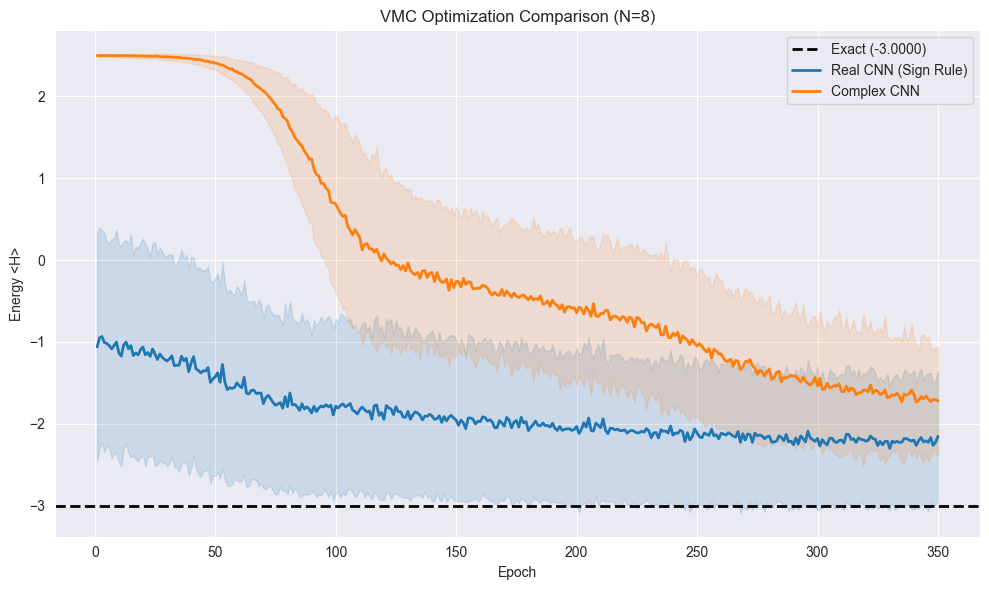

In [ ]:
def main():
    config_cnn = {
        'n_spins': 8,
        'J1': 1.0,
        'J2': 0.5,
        'lr': 0.001,
        'n_epochs': 1500,
        'batch_size': 512,
        'mcmc_steps': 10,
        'device': torch.device("cuda" if torch.cuda.is_available() else "cpu")
    }
    config_sin = {
        'n_spins': 8,
        'J1': 1.0,
        'J2': 0.5,
        'lr': 0.001,
        'n_epochs': 1500,
        'batch_size': 512,
        'mcmc_steps': 10,
        'device': torch.device("cuda" if torch.cuda.is_available() else "cpu")
    }
    
    # 1. Baseline
    solver = QuantumJ1J2Solver(config_cnn['n_spins'], config_cnn['J1'], config_cnn['J2'])
    exact_E = solver.ground_state_energy
    print(f"Target Exact Energy: {exact_E:.4f}")

    results = {}
    
    # 2. Run Experiments
    
    # # Model A: Real CNN + Marshall Sign Rule
    # mean_cnn, std_cnn = train_vmc_model(
    #     J1J2CNNLogWavefunction, 
    #     compute_local_energy_log, 
    #     J2_val=config_cnn['J2'], 
    #     config=config_cnn
    # )
    # results["Real CNN (Sign Rule)"] = {'mean': mean_cnn, 'std': std_cnn}
    
    # Model B: Complex Sine MLP (Learns Phase)
    # Using the class defined above as a stand-in for 'SineKAN_NQS'
    mean_complex_cnn, std_complex_cnn = train_vmc_model(
        ComplexCNN, 
        compute_energy_complex_robust, 
        J2_val=config_sin['J2'],
        config=config_sin
    )
    results["Complex CNN"] = {'mean': mean_complex_cnn, 'std': std_complex_cnn}

    # 3. Plot
    plot_results(results, exact_E, config_cnn['n_spins'])

if __name__ == "__main__":
    main()

Starting Experiments on cpu for N=10...

================ [ J2 = 0.0 ] ================
--> Training Real CNN...
Training J1J2CNNLogWavefunction...
    Epoch 001 | <E> = -2.2256
    Epoch 025 | <E> = -2.3859
    Epoch 050 | <E> = -2.7632
    Final Energy: -2.7632
--> Training Complex CNN...
Training ComplexCNN...
    Epoch 001 | <E> = 2.2493
    Epoch 025 | <E> = 2.2416
    Epoch 050 | <E> = 2.1728
    Final Energy: 2.1728

================ [ J2 = 0.5 ] ================
--> Training Real CNN...
Training J1J2CNNLogWavefunction...
    Epoch 001 | <E> = -1.2156
    Epoch 025 | <E> = -1.4003
    Epoch 050 | <E> = -1.5918
    Final Energy: -1.5918
--> Training Complex CNN...
Training ComplexCNN...
    Epoch 001 | <E> = 3.2483
    Epoch 025 | <E> = 3.2247
    Epoch 050 | <E> = 3.0704
    Final Energy: 3.0704

================ [ J2 = 1.0 ] ================
--> Training Real CNN...
Training J1J2CNNLogWavefunction...
    Epoch 001 | <E> = -0.2453
    Epoch 025 | <E> = -0.4887
    Epoch 050 | <E

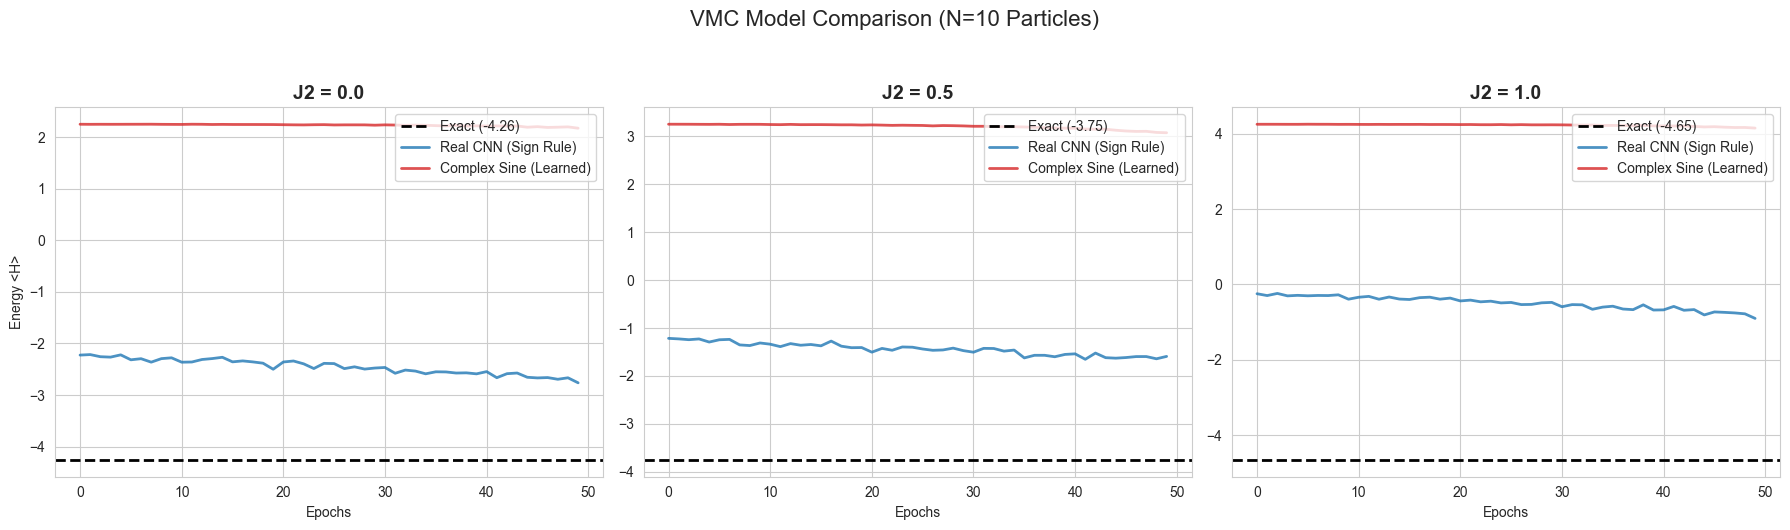

In [ ]:
def main():
    config = {
        'n_spins': 10,  # Fixed at 10
        'J1': 1.0,
        'lr': 0.0005,
        'n_epochs': 50,
        'batch_size': 1024, 
        'mcmc_steps': 20,
        'depth_1': 32, 
        'depth_2': 64,
        'kernel_size': 3,
        'device': torch.device("cuda" if torch.cuda.is_available() else "cpu")
    }
    
    J2_list = [0.0, 0.5, 1.0]
    results_store = {}
    
    print(f"Starting Experiments on {config['device']} for N={config['n_spins']}...")

    for J2 in J2_list:
        print(f"\n================ [ J2 = {J2} ] ================")
        
        # 1. Get Baseline
        exact_E = QuantumJ1J2Solver(config['n_spins'], config['J1'], J2).ground_state_energy
        
        # 2. Train Real CNN (With Sign Rule)
        # print("--> Training Real CNN...")
        # cnn_hist, _ = train_vmc_model(J1J2CNNLogWavefunction, compute_local_energy_log, J2, config)
        # print(f"    Final Energy: {cnn_hist[-1]:.4f}")
        
        # 3. Train Complex Sine (Learned Phase)
        print("--> Training Complex CNN...")
        sine_hist, _ = train_vmc_model(ComplexCNN, compute_energy_complex_robust, J2, config)
        print(f"    Final Energy: {sine_hist[-1]:.4f}")
        
        results_store[J2] = {
            'exact': exact_E,
            # 'cnn': cnn_hist,
            'complexcnn': sine_hist
        }

    # 4. Generate Plot
    plot_j2_comparison(results_store, config['n_spins'])

if __name__ == "__main__":
    main()

[INFO] Global seed set to 123

[INFO] Running CNN experiment...

Starting VMC Training...
Epoch  20 | Energy: 1.2445 +/- 9.2733
Epoch  40 | Energy: -0.6121 +/- 18.5860
Epoch  60 | Energy: 2.4466 +/- 60.8127
Epoch  80 | Energy: -2.9354 +/- 0.8202
Epoch 100 | Energy: -2.9352 +/- 0.8203
Epoch 120 | Energy: -2.9352 +/- 0.8203
Epoch 140 | Energy: -2.9351 +/- 0.8203
Epoch 160 | Energy: -2.9350 +/- 0.8204
Epoch 180 | Energy: -2.9349 +/- 0.8204
Epoch 200 | Energy: -2.9348 +/- 0.8205
Done.

[INFO] All experiments finished. Check the 'plots/' folder for results.


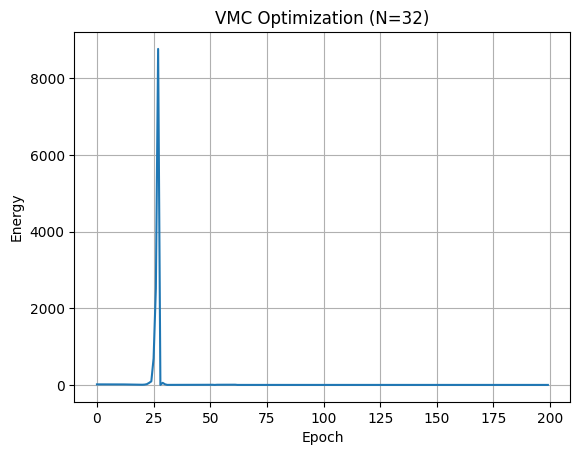

In [4]:

set_seed(123)

print("\n[INFO] Running CNN experiment...\n")
run_cnn(n_spins=32)

print("\n[INFO] All experiments finished. Check the 'plots/' folder for results.")
